### data processing

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

In [2]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':70})

In [3]:
df = pd.read_csv('PDS/Q4_2013_Groupon_North_America_Data_XLSX (1).csv')

In [4]:
df = df[df['Units Sold']!=0]
df = df[df['Billings']!=0]

In [5]:
df

,Deal ID,Units Sold,Billings,Start Date,Deal URL,Segment,Inventory Type
1,006-c000000a-hh-zv,10.90,283.400,5/10/13,http://www.groupon.com/deals/006-c000000a-hh-zv,Local,Third - Party
2,006-c000000a-hh-zv-2,11.25,934.000,7/26/13,http://www.groupon.com/deals/006-c000000a-hh-zv-2,Local,Third - Party
3,007-paintball-3,142.20,7745.800,10/31/13,http://www.groupon.com/deals/007-paintball-3,Local,Third - Party
4,02-breathe,2.90,36.250,10/4/13,http://www.groupon.com/deals/02-breathe,Local,Third - Party
5,1-2-price-boxes,18.20,182.000,10/31/13,http://www.groupon.com/deals/1-2-price-boxes,Local,Third - Party
...,...,...,...,...,...,...,...
138528,zuri-wine-tasting-2,18.85,1286.150,11/20/13,http://www.groupon.com/deals/zuri-wine-tasting-2,Local,Third - Party
138529,zweiback-aesthetics-1,49.60,9895.200,6/26/13,http://www.groupon.com/deals/zweiback-aestheti...,Local,Third - Party
138530,zweiback-aesthetics-3,13.20,2956.800,7/12/13,http://www.groupon.com/deals/zweiback-aestheti...,Local,Third - Party
138531,zz-gators-pizza-and-pub,68.60,875.314,8/24/13,http://www.groupon.com/deals/zz-gators-pizza-a...,Local,Third - Party


In [6]:
df.dtypes

Deal ID            object
Units Sold        float64
Billings          float64
Start Date         object
Deal URL           object
Segment            object
Inventory Type     object
dtype: object

In [7]:
df.isnull().sum()

Deal ID           0
Units Sold        0
Billings          0
Start Date        0
Deal URL          0
Segment           0
Inventory Type    0
dtype: int64

In [8]:
df.describe()

,Units Sold,Billings
count,111760.000000,1.117600e+05
mean,221.216327,6.818364e+03
std,957.631068,3.074609e+04
min,-9100.000000,-2.180629e+05
25%,9.500000,4.002000e+02
50%,35.150000,1.488000e+03
75%,137.400000,4.975000e+03
max,62500.000000,2.874885e+06


negative units and billings represent returns

### eda

Want to see Billings by start date in 4Q2013

In [9]:
def billingL2(df):
    df = df[['Units Sold','Billings','Start Date']].groupby(by=['Start Date']).sum().reset_index()
    df['Start Date'] = pd.to_datetime(df['Start Date'], format = '%m/%d/%y')
    return df.sort_values(by='Start Date').reset_index(drop=True)

In [10]:
dailydf = billingL2(df)

Text(0.5, 1.0, '4Q2013 Total Billings by Start Date')

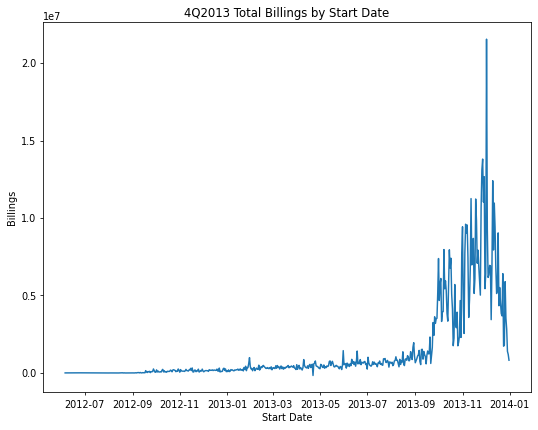

In [11]:
sns.lineplot(data=dailydf, x='Start Date', y='Billings')
plt.title('4Q2013 Total Billings by Start Date')

most of 4Q13 billings came from deals that started in Q4. Can clearly see a drop from 10/20/2013 to 10/30/2013 due to system being down and not collecting data of new deals in local segment.

Text(0.5, 1.0, '4Q2013 Total Units Sold by Start Date')

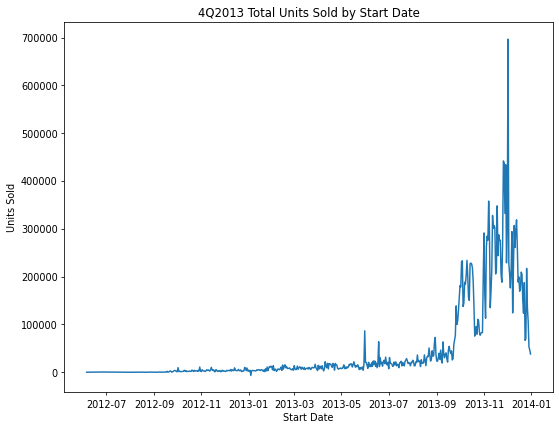

In [12]:
sns.lineplot(data=dailydf, x='Start Date', y='Units Sold')
plt.title('4Q2013 Total Units Sold by Start Date')

looking at returns by start date

In [13]:
negdf = df[df['Billings']<0]
negdf = billingL2(negdf)

Text(0.5, 1.0, '4Q2013 Total Return Billings by Start Date')

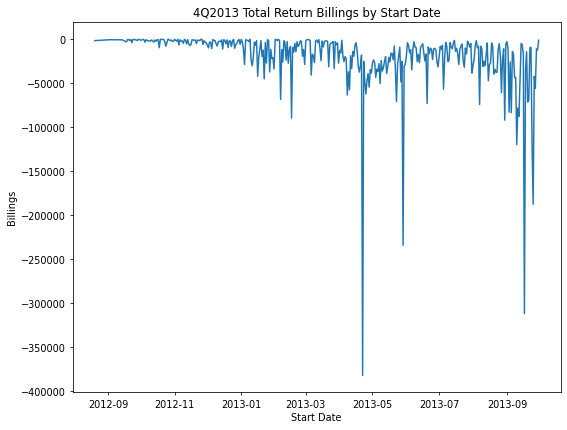

In [14]:
sns.lineplot(data=negdf, x='Start Date', y='Billings')
plt.title('4Q2013 Total Return Billings by Start Date')

Large returns deals from 4/2013 - 6/2013

#### breaking df into segments

In [15]:
localdf = billingL2(df[df['Segment'] == 'Local'])
goodsdf = billingL2(df[df['Segment'] == 'Goods'])
traveldf = billingL2(df[df['Segment'] == 'Travel'])

### Predicting missing values with ARIMA (LOCAL SEGMENT)

In [16]:
# taking a look at rolling average
localdf['rollmean7'] = localdf['Billings'].rolling(7,center=True,min_periods=1).mean()

Text(0.5, 1.0, '4Q2013 Local Billings by Start Date')

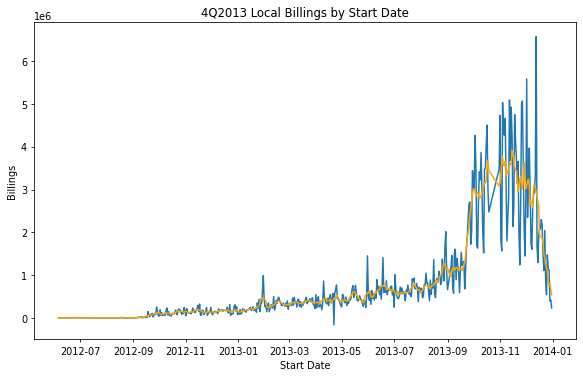

In [17]:
plt.figure(figsize=(10,6))
sns.lineplot(data=localdf, x='Start Date', y='Billings')
sns.lineplot(data=localdf, x='Start Date', y='rollmean7', color = 'orange')
plt.title('4Q2013 Local Billings by Start Date')

Orange line is 7 day rolling average for billings in the local segment. Normally I would impute missing data with rolling average or other interpolation methods. However I believe ARIMA timeseries should provide better results.

In [18]:
#creating dataframe up to 10/19/2013
arimadf = localdf.iloc[0:433,:]
arimabill = arimadf[['Start Date', 'Billings']]#.set_index('Start Date', drop=True)

#### Finding differencing (d) to stationary

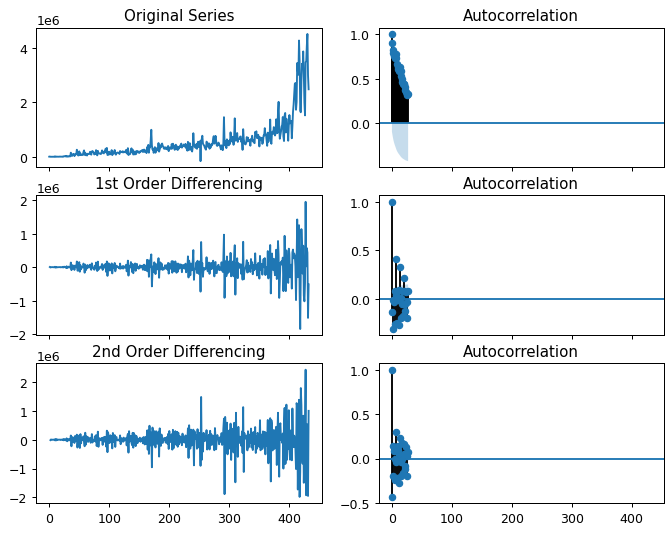

In [19]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':90})
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(arimabill.Billings); axes[0, 0].set_title('Original Series')
plot_acf(arimabill.Billings, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(arimabill.Billings.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(arimabill.Billings.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(arimabill.Billings.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(arimabill.Billings.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

#### partial correlation to find lag

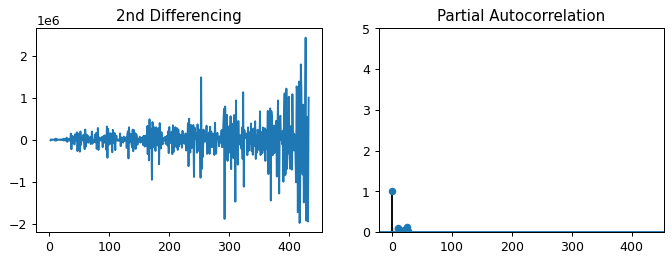

In [20]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':90})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(arimabill.Billings.diff().diff()); axes[0].set_title('2nd Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(arimabill.Billings.diff().diff().dropna(), ax=axes[1])

plt.show()

#### fitting ARIMA model

In [21]:
arimabill2 = arimadf[['Start Date', 'Billings']].set_index('Start Date', drop=True)
arimabill2.index = pd.DatetimeIndex(arimabill2.index).to_period('D')
arimabill2['Billings'] = arimabill2['Billings'].astype(float)

In [22]:
arimabill2

,Billings
Start Date,
2012-06-06,4.253200e+03
2012-06-26,9.319500e+03
2012-07-21,2.616000e+02
2012-07-29,4.698000e+02
2012-07-31,1.580500e+03
...,...
2013-10-15,3.501416e+06
2013-10-16,4.072212e+06
2013-10-17,4.507996e+06


In [23]:
model = ARIMA(arimabill2, order=(7,2,0))
model_fit = model.fit(disp=0)

#### taking a look at residuals errors

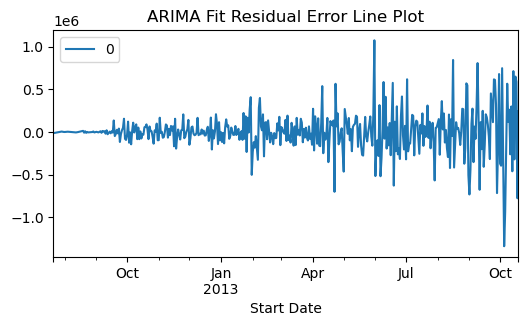

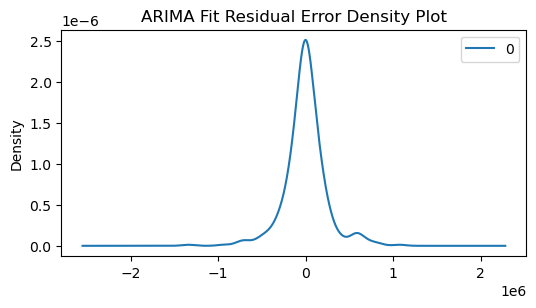

In [24]:
plt.rcParams.update({'figure.figsize':(6,3), 'figure.dpi':100})
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.title('ARIMA Fit Residual Error Line Plot')
plt.show()

residuals.plot(kind='kde')
plt.title('ARIMA Fit Residual Error Density Plot')
plt.show()

In [25]:
#training on dates up to 8/15/2013
#testing on dates 8/16/2013 to 10/19/2013
def modelfitpredict(values, plot_type):
    X = values
    size = int(len(X) * 0.85)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()

    for t in range(len(test)):
        model = ARIMA(history, order=(7,2,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)

    error = mse(test, predictions)
    print('Test MSE: %.3f' % error)
    
    if(plot_type==1):
        plt.plot(test)
        plt.plot(predictions, color='red')
        plt.legend(['test','prediction'])
        plt.title('prediction on test data')
        plt.ylabel('Millions $')
        plt.show()
        
    elif(plot_type==2):
        plt.plot(test)
        plt.plot(predictions, color='red')
        plt.legend(['test','prediction'])
        plt.title('prediction on test data')
        plt.ylabel('Units Sold')
        plt.show()
    
    

Test MSE: 275796580078.752


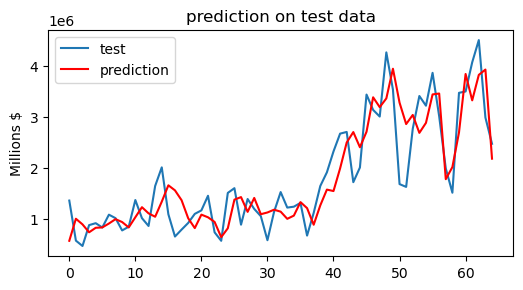

Text(0, 0.5, 'Millions $')

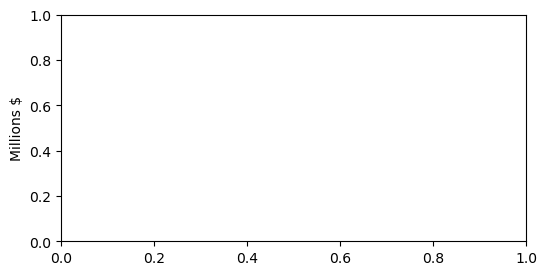

In [26]:
modelfitpredict(arimabill2.values,1)
#BILLING PREDICTION dates 8/16/2013 to 10/19/2013

In [27]:
missingdays = pd.DataFrame()
missingdays['Start Date'] = pd.date_range(start = '2013/10/20', end = '2013/10/30', freq = 'D')
missingdays.index = missingdays['Start Date']
missingdays['Billings'] = ''
missingdays = missingdays.drop(columns=['Start Date'])

In [28]:
arimabill2 = arimabill2.append(missingdays)

In [29]:
arimabill2

,Billings
Start Date,
2012-06-06,4253.2
2012-06-26,9319.5
2012-07-21,261.6
2012-07-29,469.8
2012-07-31,1580.5
...,...
2013-10-26 00:00:00,
2013-10-27 00:00:00,
2013-10-28 00:00:00,


In [30]:
X = arimabill2.values
#433. 434
train, test = X[0:433], X[433:len(X)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(7,2,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = yhat
    history.append(obs)
    


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Text(0.5, 0, 'days')

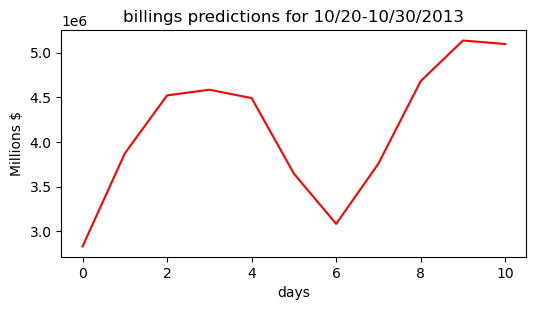

In [31]:
plt.plot(predictions,color = 'red')
plt.title('billings predictions for 10/20/2013-10/30/2013')
plt.ylabel('Millions $')
plt.xlabel('days')

In [32]:
#creating local prediction df
localdfadd = pd.DataFrame()
localdfadd['Start Date'] = pd.date_range(start = '2013/10/20', end = '2013/10/30', freq = 'D')
localdfadd['Billings'] = np.concatenate(predictions).ravel().tolist()

In [33]:
localdfadd

,Start Date,Billings
0,2013-10-20,2.829064e+06
1,2013-10-21,3.872275e+06
2,2013-10-22,4.522955e+06
3,2013-10-23,4.586653e+06
4,2013-10-24,4.492495e+06
5,2013-10-25,3.644787e+06
6,2013-10-26,3.081985e+06
7,2013-10-27,3.758489e+06
8,2013-10-28,4.683628e+06
9,2013-10-29,5.138354e+06


#### using same method to predict units sold 10/20-10/30

In [34]:
arimaunits = arimadf[['Start Date', 'Units Sold']]
arimaunits2 = arimadf[['Start Date', 'Units Sold']].set_index('Start Date', drop=True)
arimaunits2.index = pd.DatetimeIndex(arimaunits2.index).to_period('D')

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Test MSE: 513680504.405


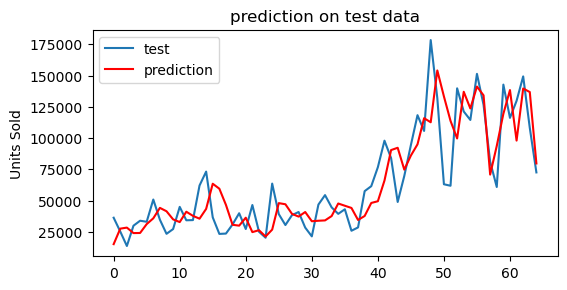

In [35]:
modelfitpredict(arimaunits2.values,2)
#UNITS SOLD PREDICTION dates 8/16/2013 to 10/19/2013

In [36]:
missingdays = pd.DataFrame()
missingdays['Start Date'] = pd.date_range(start = '2013/10/20', end = '2013/10/30', freq = 'D')
missingdays.index = missingdays['Start Date']
missingdays['Units Sold'] = ''
missingdays = missingdays.drop(columns=['Start Date'])
arimaunits2 = arimaunits2.append(missingdays)

In [37]:
X = arimaunits2.values
#433. 434
train, test = X[0:433], X[433:len(X)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(7,2,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = yhat
    history.append(obs)
    

Text(0.5, 0, 'days')

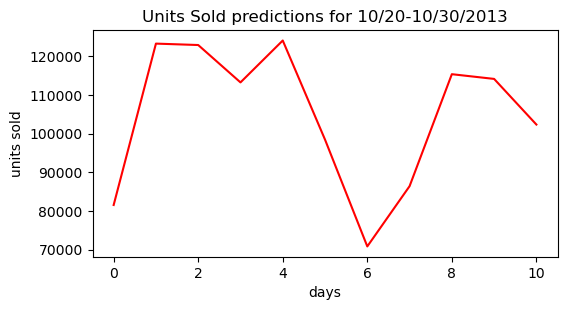

In [38]:
plt.plot(predictions,color = 'red')
plt.title('Units Sold predictions for 10/20-10/30/2013')
plt.ylabel('units sold')
plt.xlabel('days')

In [39]:
localdfadd['Units Sold'] = np.concatenate(predictions).ravel().tolist()

In [40]:
localdfadd

,Start Date,Billings,Units Sold
0,2013-10-20,2.829064e+06,81580.759196
1,2013-10-21,3.872275e+06,123327.245172
2,2013-10-22,4.522955e+06,122961.229661
3,2013-10-23,4.586653e+06,113292.126686
4,2013-10-24,4.492495e+06,124127.123345
5,2013-10-25,3.644787e+06,98488.086485
6,2013-10-26,3.081985e+06,70862.760822
7,2013-10-27,3.758489e+06,86448.627420
8,2013-10-28,4.683628e+06,115415.310212
9,2013-10-29,5.138354e+06,114195.983571


#### Q4 TOTAL estimation after gap fill 10/20 - 10/30

In [41]:
localdf = billingL2(df[df['Segment'] == 'Local'])
goodsdf = billingL2(df[df['Segment'] == 'Goods'])
traveldf = billingL2(df[df['Segment'] == 'Travel'])

In [42]:
localdf = localdf.append(localdfadd, ignore_index= True)
localdf = localdf.sort_values(by=['Start Date'])

In [43]:
# local Q4
localdf.sum()

Units Sold    1.507757e+07
Billings      4.549326e+08
dtype: float64

In [44]:
# goods Q4
goodsdf.sum()

Units Sold    1.041975e+07
Billings      2.822457e+08
dtype: float64

In [45]:
# travel Q4
traveldf.sum()

Units Sold    3.789102e+05
Billings      7.055206e+07
dtype: float64

### new deals estimation

In [46]:
df = pd.read_csv('PDS/Q4_2013_Groupon_North_America_Data_XLSX (1).csv')

In [47]:
df['start month'] = df['Start Date'].str.split('/').str[0].astype(int)

In [48]:
df

,Deal ID,Units Sold,Billings,Start Date,Deal URL,Segment,Inventory Type,start month
0,001c000000v3rpl,0.00,0.000,8/19/13,http://www.groupon.com/deals/001c000000v3rpl,Local,Third - Party,8
1,006-c000000a-hh-zv,10.90,283.400,5/10/13,http://www.groupon.com/deals/006-c000000a-hh-zv,Local,Third - Party,5
2,006-c000000a-hh-zv-2,11.25,934.000,7/26/13,http://www.groupon.com/deals/006-c000000a-hh-zv-2,Local,Third - Party,7
3,007-paintball-3,142.20,7745.800,10/31/13,http://www.groupon.com/deals/007-paintball-3,Local,Third - Party,10
4,02-breathe,2.90,36.250,10/4/13,http://www.groupon.com/deals/02-breathe,Local,Third - Party,10
...,...,...,...,...,...,...,...,...
138529,zweiback-aesthetics-1,49.60,9895.200,6/26/13,http://www.groupon.com/deals/zweiback-aestheti...,Local,Third - Party,6
138530,zweiback-aesthetics-3,13.20,2956.800,7/12/13,http://www.groupon.com/deals/zweiback-aestheti...,Local,Third - Party,7
138531,zz-gators-pizza-and-pub,68.60,875.314,8/24/13,http://www.groupon.com/deals/zz-gators-pizza-a...,Local,Third - Party,8
138532,zzfoto,0.00,0.000,12/26/13,http://www.groupon.com/deals/zzfoto,Local,Third - Party,12


In [49]:
def nds(df,segment):
#counted new deals for each month 1-12 that was billed in Q4
    nds_list = list()
    for i in range(0,12):
        nds_list.append(len(df[(df['Segment']==segment) & (df['start month']==i+1)]))
    return nds_list

In [50]:
nds_local = nds(df,'Local')

In [51]:
#local new deals by month start date 0-12
nds_local

[2528, 3555, 5306, 7776, 8874, 7711, 9593, 10761, 12457, 12805, 19322, 19888]

In [52]:
#October20-30, system down and no new deals were recorded. October deals reflect only 20 days. 
#Will proportionately calculate estimated deals of missing days

nds_local[9] = nds_local[9]/2*3

Text(0.5, 1.0, 'local deals billed in Q4')

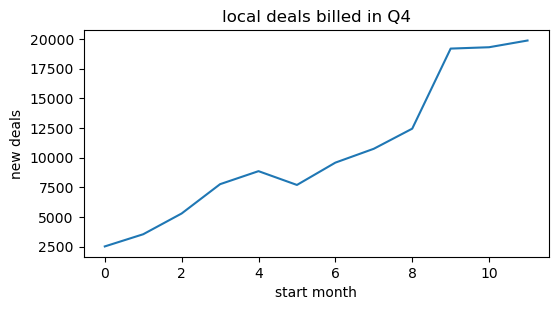

In [53]:
plt.plot(nds_local)
plt.xlabel('start month')
plt.ylabel('new deals')
plt.title('local deals billed in Q4')

In [54]:
nds_travel = nds(df,'Travel')
nds_goods = nds(df,'Goods')

In [55]:
#travel new deals by month start date 0-12
nds_travel

[0, 0, 1, 26, 6, 5, 5, 92, 412, 466, 855, 856]

In [56]:
#goods new deals by month start date 0-12
nds_goods

[0, 0, 17, 323, 367, 369, 340, 252, 816, 3649, 4520, 4581]

#### Q4 prediction breakdown by month 10,11,12 using percentile split DF

Since we found all totals, now it's time to breakdown totals by month. I created a predicted percentile breakdown csv which further explained in my word doc.

In [57]:
percentile = pd.read_csv('PDS/percentile_split.csv')

In [58]:
percentile

,Unnamed: 0,Local Billings,Goods Billings,Travel Billings,Total Billings,Local Units Sold,Goods Units Sold,Travel Units Sold,Total Units Sold,New Deals Started Local,New Deals Started Goods,New Deals Started Travel,New Deals Started Total
0,10/1/13,0.309202,0.300647,0.339220,NaN,0.328778,0.297187,0.300853,NaN,NaN,NaN,NaN,NaN
1,11/1/13,0.327398,0.371237,0.302969,NaN,0.318663,0.375723,0.342162,NaN,NaN,NaN,NaN,NaN
2,12/1/13,0.363400,0.328115,0.357811,NaN,0.352559,0.327090,0.356986,NaN,NaN,NaN,NaN,NaN


In [59]:
finaldf = percentile

In [60]:
#multiply Total Billings by Q4 month breakdown
finaldf['Local Billings'] = percentile['Local Billings'] * localdf.sum()[1]
finaldf['Goods Billings'] = percentile['Goods Billings'] * goodsdf.sum()[1]
finaldf['Travel Billings'] = percentile['Travel Billings'] * traveldf.sum()[1]
finaldf['Total Billings'] = finaldf['Local Billings'] + finaldf['Goods Billings'] +finaldf['Travel Billings']

In [61]:
#multiply Total Units Sold by Q4 month breakdown
finaldf['Local Units Sold'] = percentile['Local Units Sold'] * localdf.sum()[0]
finaldf['Goods Units Sold'] = percentile['Goods Units Sold'] * goodsdf.sum()[0]
finaldf['Travel Units Sold'] = percentile['Travel Units Sold'] * traveldf.sum()[0]
finaldf['Total Units Sold'] = finaldf['Local Units Sold'] + finaldf['Goods Units Sold'] +finaldf['Travel Units Sold']

In [62]:
#fill in new deals 
finaldf.iloc[0,9] = nds_local[9]
finaldf.iloc[1,9] = nds_local[10]
finaldf.iloc[2,9] = nds_local[11]

finaldf.iloc[0,10] = nds_goods[9]
finaldf.iloc[1,10] = nds_goods[10]
finaldf.iloc[2,10] = nds_goods[11]

finaldf.iloc[0,11] = nds_travel[9]
finaldf.iloc[1,11] = nds_travel[10]
finaldf.iloc[2,11] = nds_travel[11]

finaldf['New Deals Started Total'] = finaldf.iloc[:,9] + finaldf.iloc[:,10] + finaldf.iloc[:,11]

In [63]:
finaldf

,Unnamed: 0,Local Billings,Goods Billings,Travel Billings,Total Billings,Local Units Sold,Goods Units Sold,Travel Units Sold,Total Units Sold,New Deals Started Local,New Deals Started Goods,New Deals Started Travel,New Deals Started Total
0,10/1/13,1.406662e+08,8.485643e+07,2.393266e+07,2.494553e+08,4.957167e+06,3.096614e+06,113996.154075,8.167778e+06,19207.5,3649.0,466.0,23322.5
1,11/1/13,1.489438e+08,1.047801e+08,2.137509e+07,2.750991e+08,4.804665e+06,3.914936e+06,129648.556285,8.849249e+06,19322.0,4520.0,855.0,24697.0
2,12/1/13,1.653225e+08,9.260911e+07,2.524431e+07,2.831759e+08,5.315736e+06,3.408196e+06,135265.489640,8.859198e+06,19888.0,4581.0,856.0,25325.0


In [64]:
submit = finaldf

In [65]:
submit.iloc[:,1:5] = submit.iloc[:,1:5]/1000000.0

In [66]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [67]:
submit

,Unnamed: 0,Local Billings,Goods Billings,Travel Billings,Total Billings,Local Units Sold,Goods Units Sold,Travel Units Sold,Total Units Sold,New Deals Started Local,New Deals Started Goods,New Deals Started Travel,New Deals Started Total
0,10/1/13,140.66623,84.85643,23.93266,249.45531,4957167.30757,3096614.44732,113996.15408,8167777.90896,19207.50000,3649.00000,466.00000,23322.50000
1,11/1/13,148.94384,104.78013,21.37509,275.09907,4804664.52438,3914935.74606,129648.55628,8849248.82672,19322.00000,4520.00000,855.00000,24697.00000
2,12/1/13,165.32252,92.60911,25.24431,283.17594,5315735.96370,3408196.11062,135265.48964,8859197.56397,19888.00000,4581.00000,856.00000,25325.00000
